In [1]:
import random
from argparse import ArgumentParser
from decimal import Decimal
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
import numpy as np
from preprocess_data import clean_data, create_balance_df, parse_and_assign_cex, parse_html
from analyze_data import *
import os.path

pd.options.display.max_colwidth = 100
pd.options.display.width = 0
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False

Load data files

In [2]:
file_balances_uni = "../data/uni.csv"
file_original_uni = "../data/outputUNI_fromBlock_10861674_toBlock_20000000.csv"
timelock_address_uni = "0x1a9c8182c09f50c8318d769245bea52c32be35bc"

In [3]:
file_balances_mkr = "../data/mkr.csv"
file_original_mkr = "../data/outputMKR_fromBlock_4620855_toBlock_20000000.csv"

In [4]:
file_balances_ldo = "../data/ldo.csv"
file_original_ldo = "../data/outputLDO_fromBlock_11473276_toBlock_20000000.csv"

Initialize data frames

In [5]:
df_uni_full = pd.read_csv(file_balances_uni)
df_uni_full["balance"] = df_uni_full["balance"].apply(Decimal)
df_uni_full["amount_in"] = df_uni_full["amount_in"].apply(Decimal)
df_uni_full["amount_out"] = df_uni_full["amount_out"].apply(Decimal)

/tmp/ipykernel_47304/708309094.py:1: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uni_full = pd.read_csv(file_balances_uni)


In [6]:
df_mkr_full = pd.read_csv(file_balances_mkr)
df_mkr_full["balance"] = df_mkr_full["balance"].apply(Decimal)
df_mkr_full["amount_in"] = df_mkr_full["amount_in"].apply(Decimal)
df_mkr_full["amount_out"] = df_mkr_full["amount_out"].apply(Decimal)

/tmp/ipykernel_47304/516367645.py:1: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mkr_full = pd.read_csv(file_balances_mkr)


In [7]:
df_ldo_full = pd.read_csv(file_balances_ldo)
df_ldo_full["balance"] = df_ldo_full["balance"].apply(Decimal)
df_ldo_full["amount_in"] = df_ldo_full["amount_in"].apply(Decimal)
df_ldo_full["amount_out"] = df_ldo_full["amount_out"].apply(Decimal)

Preprocess data

In [8]:
df_uni_non_negative = clean_data(df_uni_full)    # remove negative balances and sort descending
df_uni_only_positive = remove_zero_balances(df_uni_non_negative)    # remove zero balances
df_uni = remove_address(df_uni_only_positive, timelock_address_uni)

print("Number of addresses that hold tokens: \n", df_uni.shape[0])

Number of addresses that hold tokens: 
 382522


In [9]:
df_mkr_non_negative = clean_data(df_mkr_full)    # remove negative balances and sort descending
df_mkr = remove_zero_balances(df_mkr_non_negative) # remove zero balances

print("Number of addresses that hold tokens: \n", df_mkr.shape[0])

Number of addresses that hold tokens: 
 108471


In [10]:
df_ldo_non_negative = clean_data(df_ldo_full)    # remove negative balances and sort descending
df_ldo = remove_zero_balances(df_ldo_non_negative) # remove zero balances

print("Number of addresses that hold tokens: \n", df_ldo.shape[0])

Number of addresses that hold tokens: 
 44726


## Metrics

In [11]:
#df_uni.head(10)

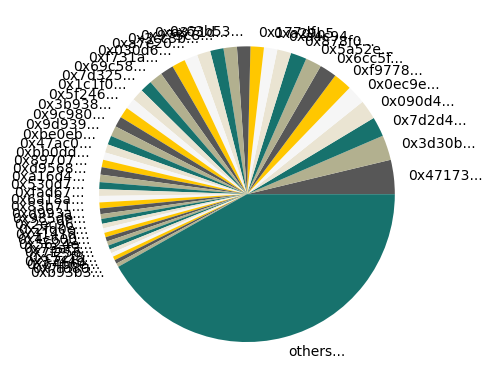

In [12]:
from matplotlib.colors import ListedColormap
df = pd.DataFrame(merge_others_at_cut_off_value(df_uni, 50))
plt.figure()
data = df["balance"].to_numpy()
addresses = df["address"].apply(lambda x: x[0:7] + "...")
labels = addresses

colors = ["#575757", "#b2b08f", "#17726d", "#eae4d2", "#f6f6f6", "#ffc700"]
# colors = random.choices(["#17726d", "#575757", "#b2b08f", "#eae4d2", "#f6f6f6", "#ffc700"], k=len(labels))
wedges, texts = plt.pie(data,
                        labels=labels,
                        colors=colors)
plt.show()

In [13]:
#df_mkr.head(10)


In [14]:
#df_ldo.head(10)

In [15]:
# uni

print_top_percentages(df_uni)
print_top_traders(df_uni)
print_transfer_frequency(file_original_uni)
print_cex_percentages(df_uni)

Top 10 percentage: 21.70%
Top 100 percentage: 73.94%
Top 1000 percentage: 95.61%


/home/luke/projects/caa-governance-tokens/src/analyze_data.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aggregated = df_aggregated.append(df[pd.isnull(df['cex'])])



Top senders: 
                                            address                      balance          cex
340204   0x41653c7d61609d856f29355e404f310ec4142cfb             2758162612694493          NaN
1                                               NaN   36697432554638172652161204      binance
153078   0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801  2389244318714231259971746.0          NaN
1095711  0xd3d2e2692501a5c9ca623199d38826e513033a17   296150534151073172965800.0          NaN
745201   0x8fdb3816fe10e16aaa9b12b3c4688c873efe2eca                 224000000000          NaN
447613   0x56178a0d5f301baf6cf3e1cd53d9863437345bf9                         2287          NaN
6                                               NaN     165471168316191250849500  coinbasepro
279335   0x35a18000230da775cac24873d00ff85bccded550  1710109454349553903820275.0          NaN
48214    0x090d4613473dee047c3f2706764f49e0821d256e   13037019770979843000000000          NaN
948567   0xb739d0895772dbb71a89a3754a16026906

In [16]:
df_uni_cex_not_None = df_uni[~pd.isnull(df_uni["cex"])]
df_uni_cex_is_None = df_uni[pd.isnull(df_uni["cex"])]

print("Number of cex addresses: ", df_uni_cex_not_None.shape[0])
print("Number of other addresses: ", df_uni_cex_is_None.shape[0])

Number of cex addresses:  43
Number of other addresses:  382479


In [17]:
# mkr

print_top_percentages(df_mkr)
print_top_traders(df_mkr)
print_transfer_frequency(file_original_mkr)
print_cex_percentages(df_mkr)

Top 10 percentage: 41.89%
Top 100 percentage: 77.95%
Top 1000 percentage: 96.53%


/home/luke/projects/caa-governance-tokens/src/analyze_data.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aggregated = df_aggregated.append(df[pd.isnull(df['cex'])])



Top senders: 
                                           address                     balance          cex
1                                              NaN   46051723732922684298025.0      binance
138722  0x642ae78fafbb8032da552d619ad43f1d81e4dd7c     10010037521254843416576          NaN
219770  0x9ef05f7f6deb616fd37ac3c959a2ddd25a54e4f5        77695907563979112448          NaN
14705   0x0a3f6849f78076aefadf113f5bed87720274ddc0  153998044112777295833409.0          NaN
6                                              NaN       899416500460108906496  coinbasepro
321271  0xe8c6c9227491c0a8156a0106a0204d881bb7e531     11358873576643288367104          NaN
283385  0xcd531ae9efcce479654c4926dec5f6209531ca7b       466081756590025211904          NaN
196697  0x8e2a84d6ade1e7fffee039a35ef5f19f13057152      1805613168429906526208          NaN
339884  0xf65475e74c1ed6d004d5240b06e3088724dfda5d      2282210762009635979264          NaN
206968  0x95a9bd206ae52c4ba8eecfc93d18eacdd41c88cc         115999

In [18]:
df_mkr_cex_not_None = df_mkr[~pd.isnull(df_mkr["cex"])]
df_mkr_cex_is_None = df_mkr[pd.isnull(df_mkr["cex"])]

print("Number of cex addresses: ", df_mkr_cex_not_None.shape[0])
print("Number of other addresses: ", df_mkr_cex_is_None.shape[0])

Number of cex addresses:  43
Number of other addresses:  108428


In [19]:
# ldo

print_top_percentages(df_ldo)
print_top_traders(df_ldo)
print_transfer_frequency(file_original_ldo)
print_cex_percentages(df_ldo)

Top 10 percentage: 52.94%
Top 100 percentage: 84.71%
Top 1000 percentage: 98.04%


/home/luke/projects/caa-governance-tokens/src/analyze_data.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aggregated = df_aggregated.append(df[pd.isnull(df['cex'])])



Top senders: 
                                           address                      balance          cex
1                                              NaN   68108806024237262903881771      binance
74783   0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74    2588549098016500368587269          NaN
5                                              NaN     641160949322622392617200  coinbasepro
93139   0xcd531ae9efcce479654c4926dec5f6209531ca7b     532649314165584727299100          NaN
89636   0xc558f600b34a5f69dd2f0d06cb8a88d829b7420a      26896046942688315807777          NaN
28503   0x3e40d73eb977dc6a537af587d48316fee66e9c8c  107622410252245548438504228          NaN
75963   0xa69babef1ca67a37ffaf7a485dfff3382056e78c      42956583096111324394459          NaN
65604   0x9008d19f58aabd9ed0d60971565aa8510560ab41       4462417641453688500055          NaN
110861  0xf4ad61db72f114be877e87d62dc5e7bd52df4d9b     214294547684153304156243          NaN
56      0x000000000dfde7deaf24138722987c9a6991e2d4     

In [20]:
df_ldo_cex_not_None = df_ldo[~pd.isnull(df_ldo["cex"])]
df_ldo_cex_is_None = df_ldo[pd.isnull(df_ldo["cex"])]

print("Number of cex addresses: ", df_ldo_cex_not_None.shape[0])
print("Number of other addresses: ", df_ldo_cex_is_None.shape[0])

Number of cex addresses:  23
Number of other addresses:  44703


### Gini index

gini index:  0.9952059161147626
gini index (top 1000):  0.8408474733014751
gini index (top 100):  0.4240152134348554

Plotting balance cdf:


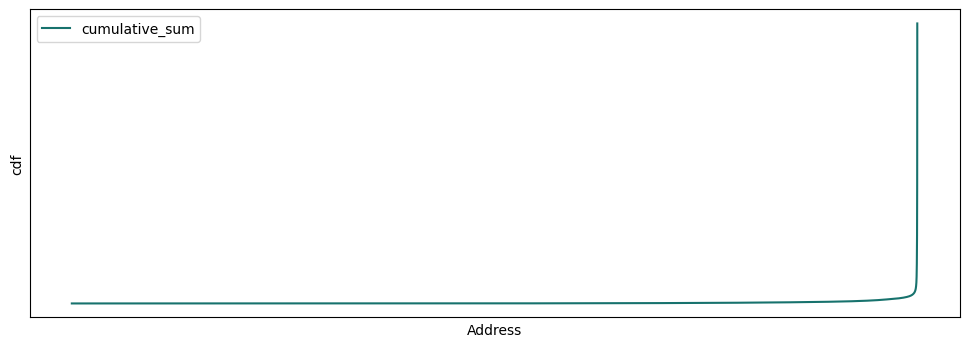

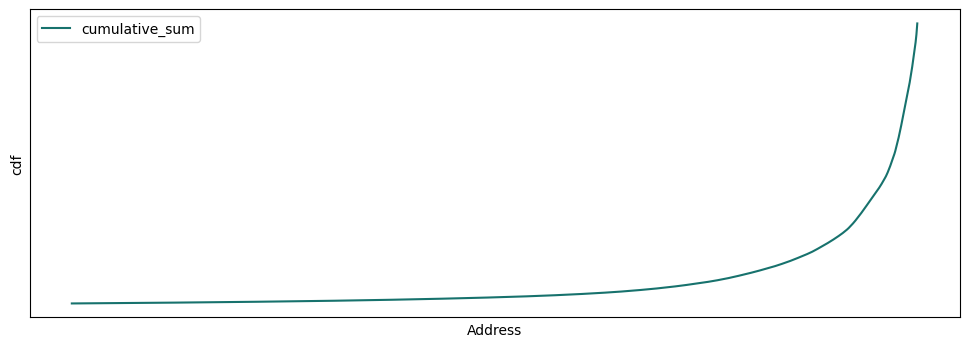

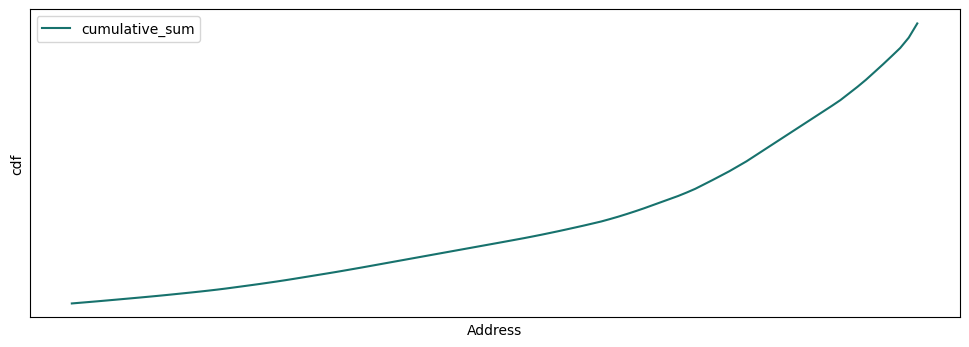

In [21]:
gini_index_uni = compute_gini_index(df_uni)
print("gini index: ", gini_index_uni)

gini_index_uni = compute_gini_index(get_top_by_balances(df_uni, 1000))
print("gini index (top 1000): ", gini_index_uni)

gini_index_uni = compute_gini_index(get_top_by_balances(df_uni, 100))
print("gini index (top 100): ", gini_index_uni)

print("\nPlotting balance cdf:")
create_balance_cdf_plot(df_uni, "../data/uni_balance_cdf")
create_balance_cdf_plot(get_top_by_balances(df_uni, 1000), "../data/uni_balance_cdf_top_1000")
create_balance_cdf_plot(get_top_by_balances(df_uni, 100), "../data/uni_balance_cdf_top_100")

gini index:  0.9955140702710944
gini index (top 1000):  0.8605121890834014
gini index (top 100):  0.6036182267643397

Plotting balance cdf:


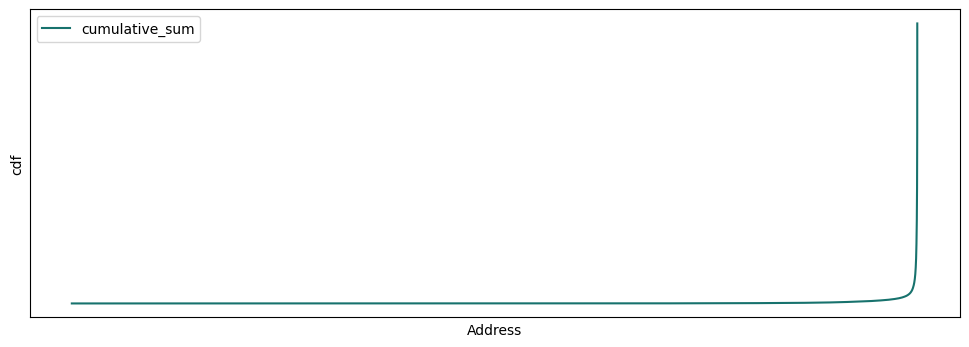

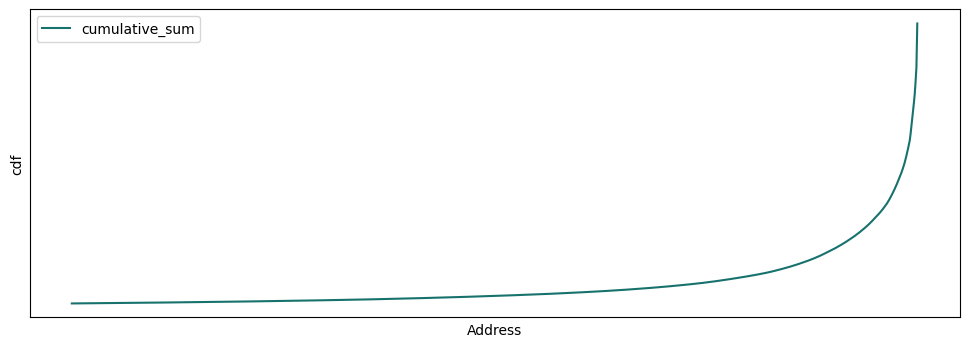

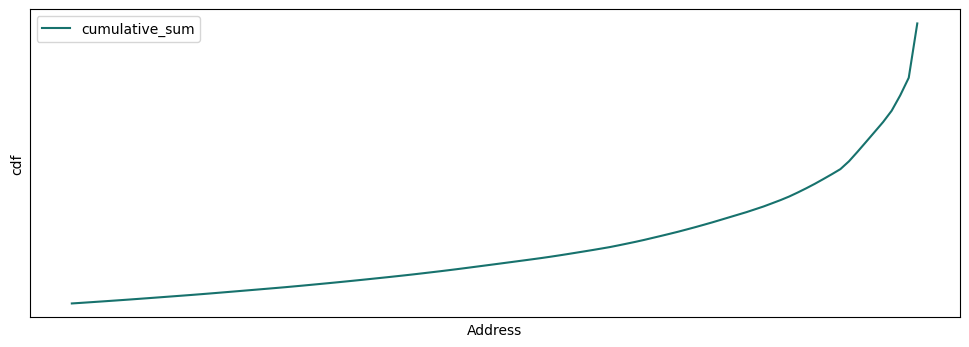

In [22]:
gini_index_mkr = compute_gini_index(df_mkr)
print("gini index: ", gini_index_mkr)

gini_index_mkr = compute_gini_index(get_top_by_balances(df_mkr, 1000))
print("gini index (top 1000): ", gini_index_mkr)

gini_index_mkr = compute_gini_index(get_top_by_balances(df_mkr, 100))
print("gini index (top 100): ", gini_index_mkr)

print("\nPlotting balance cdf:")
create_balance_cdf_plot(df_mkr, "../data/mkr_balance_cdf")
create_balance_cdf_plot(get_top_by_balances(df_mkr, 1000), "../data/mkr_balance_cdf_top_1000")
create_balance_cdf_plot(get_top_by_balances(df_mkr, 100), "../data/mkr_balance_cdf_top_100")

gini index:  0.9943440548963924
gini index (top 1000):  0.89909745726069
gini index (top 100):  0.6646104767855165

Plotting balance cdf:


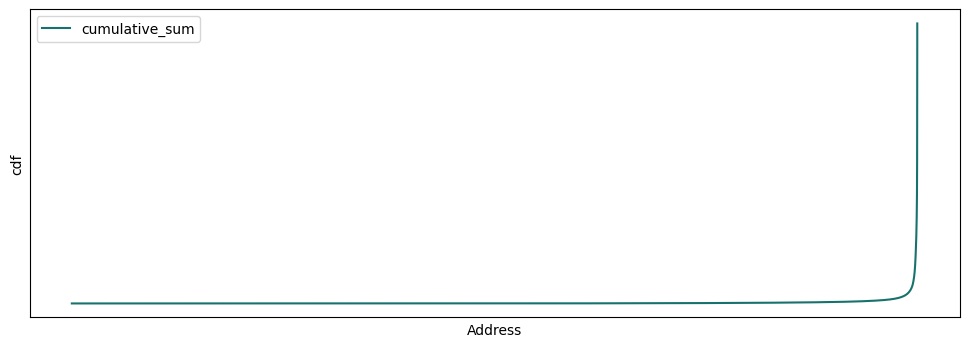

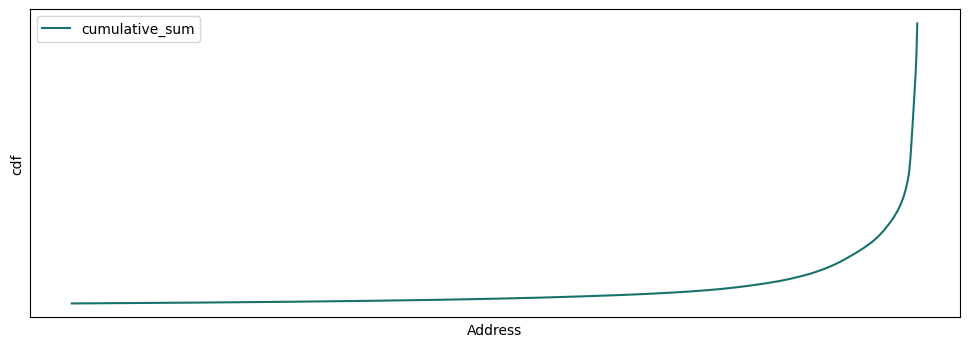

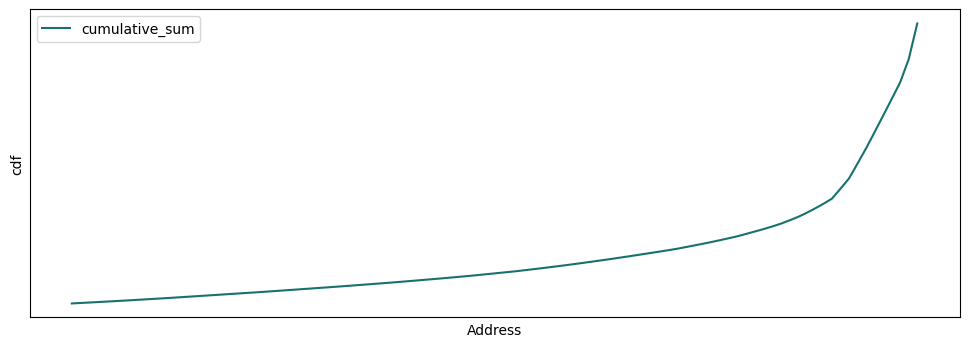

In [23]:
gini_index_ldo = compute_gini_index(df_ldo)
print("gini index: ", gini_index_ldo)

gini_index_ldo = compute_gini_index(get_top_by_balances(df_ldo, 1000))
print("gini index (top 1000): ", gini_index_ldo)

gini_index_ldo = compute_gini_index(get_top_by_balances(df_ldo, 100))
print("gini index (top 100): ", gini_index_ldo)

print("\nPlotting balance cdf:")
create_balance_cdf_plot(df_ldo, "../data/ldo_balance_cdf")
create_balance_cdf_plot(get_top_by_balances(df_ldo, 1000), "../data/ldo_balance_cdf_top_1000")
create_balance_cdf_plot(get_top_by_balances(df_ldo, 100), "../data/ldo_balance_cdf_top_100")

Plotting balance distributions


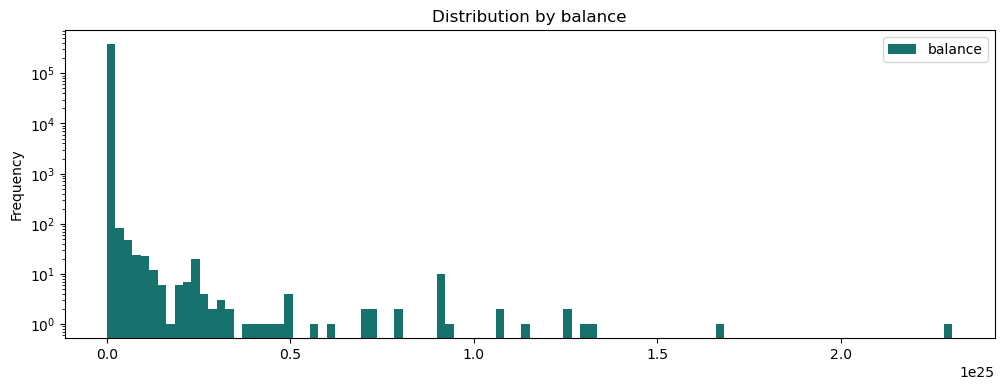

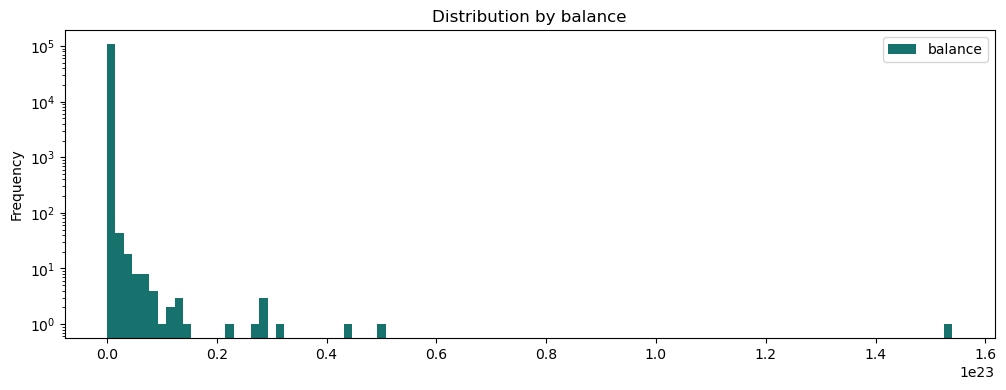

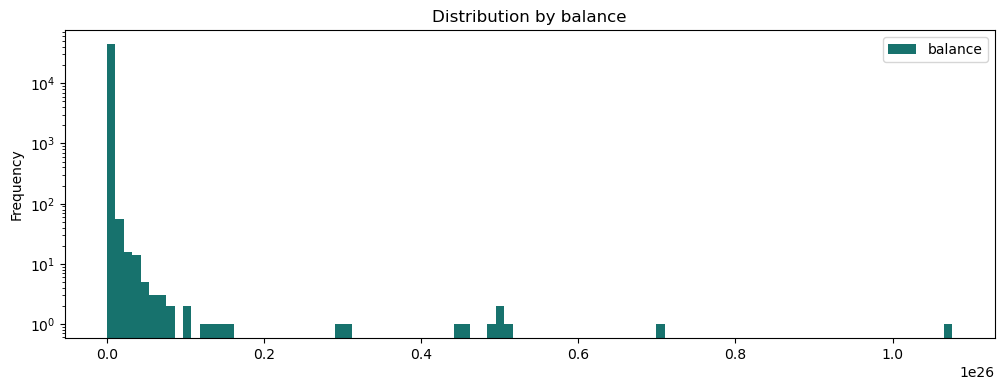

In [24]:
print("Plotting balance distributions")
create_distribution_plot(df_uni, "balance", "../data/uni_balance_dist")
create_distribution_plot(df_mkr, "balance", "../data/mkr_balance_dist")
create_distribution_plot(df_ldo, "balance", "../data/ldo_balance_dist")

### Herfindahl hirschman index:

In [25]:
hhi = compute_herfindahl_hirschman_index(df_uni)

# limited to the top n token holder
hhi = compute_herfindahl_hirschman_index(df_uni, top_n_player=1000)
hhi = compute_herfindahl_hirschman_index(df_uni, top_n_player=2)

hhi:  0.009764410451879474
hhi_normalized:  0.009761821742790174
hhi:  0.009764219894193576
hhi_normalized:  0.009761631184606113
hhi:  0.0021435903362048586
hhi_normalized:  0.0021409817044966283


In [26]:
hhi = compute_herfindahl_hirschman_index(df_mkr)

# limited to the top n token holder
hhi = compute_herfindahl_hirschman_index(df_mkr, top_n_player=1000)
hhi = compute_herfindahl_hirschman_index(df_mkr, top_n_player=2)

hhi:  0.03392086503637556
hhi_normalized:  0.03391195861861061
hhi:  0.033920598325235175
hhi_normalized:  0.033911691905011386
hhi:  0.025182331476500012
hhi_normalized:  0.025173344496980114


In [27]:
hhi = compute_herfindahl_hirschman_index(df_ldo)

# limited to the top n token holder
hhi = compute_herfindahl_hirschman_index(df_ldo, top_n_player=1000)
hhi = compute_herfindahl_hirschman_index(df_ldo, top_n_player=2)

hhi:  0.03443232806013621
hhi_normalized:  0.03441073906803023
hhi:  0.03443222164276709
hhi_normalized:  0.03441063264828174
hhi:  0.016482583188502646
hhi_normalized:  0.016460592860569466


Interpretation: The hhi index gives a different view on the distribution than the gini index. The hhi index is an indicator of the amount of competition. When we look at the hhi values in combination with the Pie Charts we see that for the Uni token we have a good competition among the top balance holders. The MKR Token on the other hand has a more uneven competition among the top balance holders and therefore a higher value (more uneven). Due to the computation of the hhi index (sum of market share), smaller market shares have "no" impact on the metric. 

## Charts

### Timeline
Gini index in timeline:

#### Uni Token:

In [28]:
block_step_size = 100_000

In [29]:
uni_timeline_file = "../data/uni_timeline_step_size_" + str(block_step_size) + ".csv"

if os.path.isfile(uni_timeline_file):
    # file already exists
    uni_timeline = pd.read_csv(uni_timeline_file)
    
else:
    uni_timeline = create_and_export_timeline(file_original_uni, block_step_size, uni_timeline_file, addresses_to_remove=["0x1a9c8182c09f50c8318d769245bea52c32be35bc"])

uni_timeline

,Unnamed: 0,block_number,gini_index,tx_per_block,hhi
0,0,10961674,0.989849,7.239988,0.065894
1,1,11061674,0.991963,1.655890,0.063920
2,2,11161674,0.993115,1.309740,0.060710
3,3,11261674,0.993525,1.263110,0.060299
4,4,11361674,0.994157,1.105370,0.056545
...,...,...,...,...,...
86,86,19561674,0.995217,0.211470,0.010341
87,87,19661674,0.995226,0.304600,0.010281
88,88,19761674,0.995180,0.222080,0.009816
89,89,19861674,0.995187,0.170590,0.009699


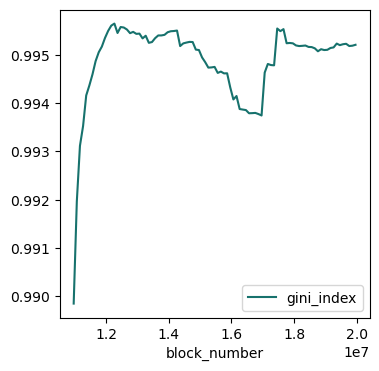

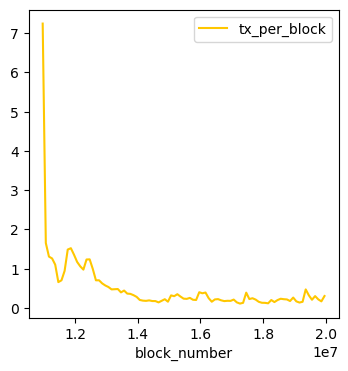

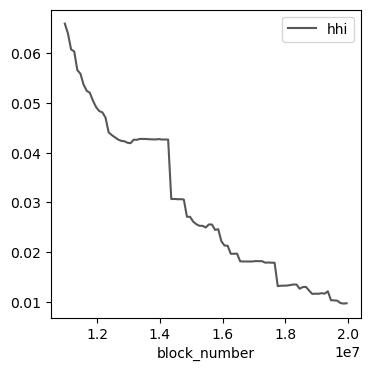

In [30]:
create_timeline_plot(uni_timeline, 'gini_index', "../data/uni_timeline_gini")
create_timeline_plot(uni_timeline, 'tx_per_block', "../data/uni_timeline_tx_per_block")
create_timeline_plot(uni_timeline, 'hhi', "../data/uni_timeline_hhi")


#### Mkr Token:

In [31]:
mkr_timeline_file = "../data/mkr_timeline_step_size_" + str(block_step_size) + ".csv"

if os.path.isfile(mkr_timeline_file):
    # file already exists
    mkr_timeline = pd.read_csv(mkr_timeline_file)
    
else:
    mkr_timeline = create_and_export_timeline(file_original_mkr, block_step_size, mkr_timeline_file)

mkr_timeline

,Unnamed: 0,block_number,gini_index,tx_per_block,hhi
0,0,4720855,0.899268,0.00029,0.994502
1,1,4820855,0.985617,0.02303,0.262063
2,2,4920855,0.987931,0.01817,0.257768
3,3,5020855,0.988059,0.02598,0.245869
4,4,5120855,0.988369,0.02571,0.244043
...,...,...,...,...,...
148,148,19520855,0.995623,0.27375,0.032071
149,149,19620855,0.995580,0.21692,0.033945
150,150,19720855,0.995577,0.28162,0.035286
151,151,19820855,0.995535,0.13951,0.034215


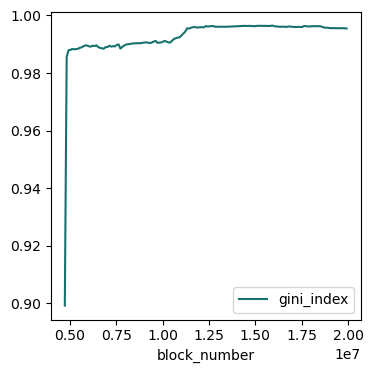

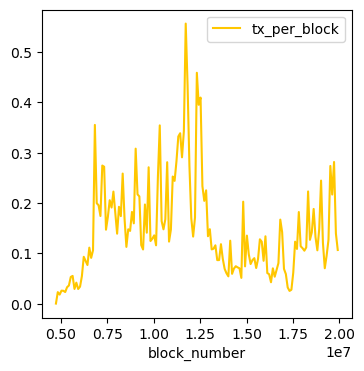

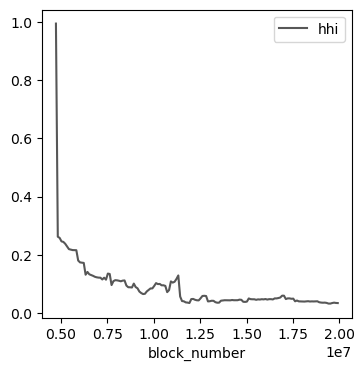

In [32]:
create_timeline_plot(mkr_timeline, 'gini_index', "../data/mkr_timeline_gini")
create_timeline_plot(mkr_timeline, 'tx_per_block', "../data/mkr_timeline_tx_per_block")
create_timeline_plot(mkr_timeline, 'hhi', "../data/mkr_timeline_hhi")

In [33]:
# TODO: Show tx frequency for all transfers (+ maybe: for top traders or cex's)

## LDO Token

In [34]:
ldo_timeline_file = "../data/ldo_timeline_step_size_" + str(block_step_size) + ".csv"

if os.path.isfile(ldo_timeline_file):
    # file already exists
    ldo_timeline = pd.read_csv(ldo_timeline_file)
    
else:
    ldo_timeline = create_and_export_timeline(file_original_ldo, block_step_size, ldo_timeline_file)

ldo_timeline

,Unnamed: 0,block_number,gini_index,tx_per_block,hhi
0,0,11573276,0.759953,0.00064,0.137866
1,1,11673276,0.979302,0.06968,0.144434
2,2,11773276,0.985454,0.06232,0.144770
3,3,11873276,0.990411,0.07877,0.141541
4,4,11973276,0.991313,0.04478,0.141422
...,...,...,...,...,...
80,80,19573276,0.994573,0.10468,0.033863
81,81,19673276,0.994515,0.09808,0.033608
82,82,19773276,0.994501,0.06390,0.033447
83,83,19873276,0.994402,0.08309,0.033310


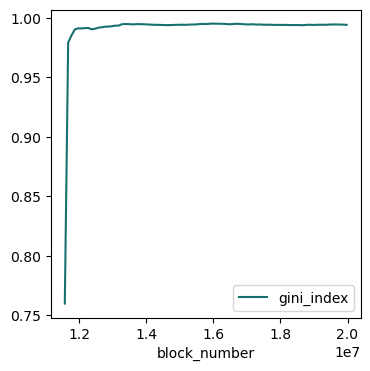

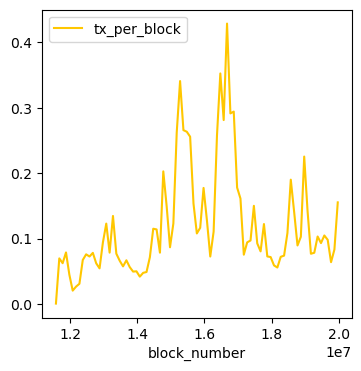

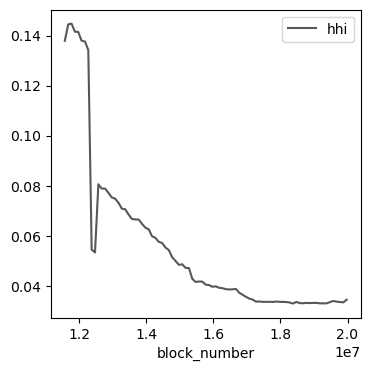

In [35]:
create_timeline_plot(ldo_timeline, 'gini_index', "../data/ldo_timeline_gini")
create_timeline_plot(ldo_timeline, 'tx_per_block', "../data/ldo_timeline_tx_per_block")
create_timeline_plot(ldo_timeline, 'hhi', "../data/ldo_timeline_hhi")

### Pie Chart
Balances distribution pie chart:

#### Uni Token:

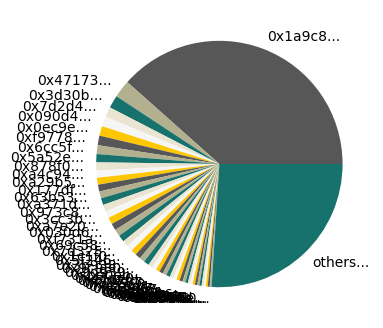

In [36]:
# all addresses with positive balance
create_pie_chart(
    merge_others_at_cut_off_value(df_uni_only_positive, 50), 
    "../data/uni_pie_chart.png")

The timelock address holds a huge amount of the tokens.

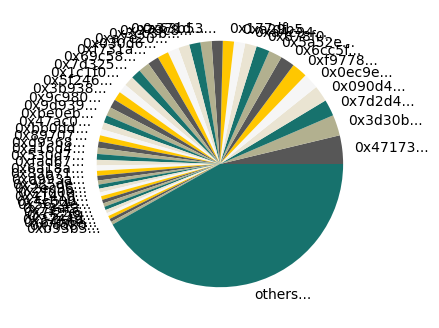

In [37]:
# all addresses with positive balance, except the timelock address
create_pie_chart(
    merge_others_at_cut_off_value(df_uni, 50), 
    "../data/uni_pie_chart_without_timelock_address.png")

        cex                     balance
1   binance  36697432554638172652161204
18     okex  11521347873058447678147604
14   kraken   2111022000000000000000000
5     bybit   2001647090445974192469061
9   gate-io    532236875036369327648747


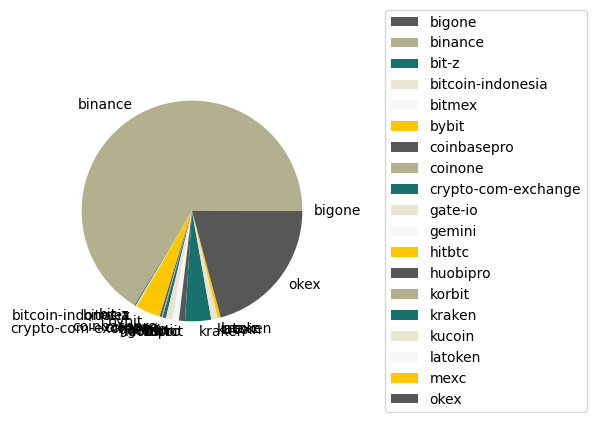

In [38]:
df_uni_cex = aggregate_cex_balances(df_uni)
print(df_uni_cex.sort_values("balance", ascending=False).head(5))

create_pie_chart(df_uni_cex, '../data/uni_pie_chart_cex.png', labels=df_uni_cex['cex'], show_legend=True)

In [39]:
# TODO make pie chart also including None exchanges

#### Mkr Token:

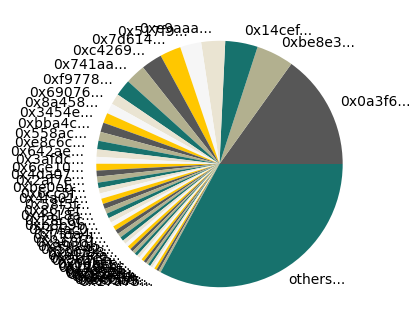

In [40]:
# all addresses with positive balance
create_pie_chart(
    merge_others_at_cut_off_value(df_mkr, 50), 
    "../data/mkr_pie_chart.png")

                    cex                    balance
1               binance  46051723732922684298025.0
17                 okex     7252042905686505123825
5                 bybit     2414339752691708723200
10               gemini     1897803982821174280192
8   crypto-com-exchange     1374716531861841045934


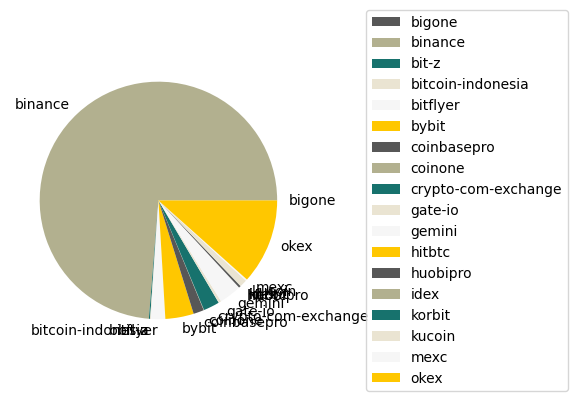

In [41]:
df_mkr_cex = aggregate_cex_balances(df_mkr)
print(df_mkr_cex.sort_values("balance", ascending=False).head(5))

create_pie_chart(df_mkr_cex, '../data/mkr_pie_chart_cex.png', labels=df_mkr_cex['cex'], show_legend=True)

## LDO Token

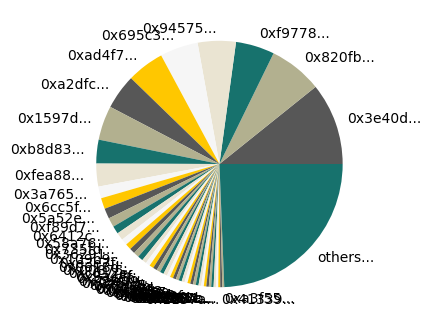

In [42]:
# all addresses with positive balance
create_pie_chart(
    merge_others_at_cut_off_value(df_ldo, 50), 
    "../data/ldo_pie_chart.png")

        cex                     balance
1   binance  68108806024237262903881771
11     okex  14339869963577690000000000
4     bybit  12154381377607532834540536
9    kucoin   1454123660164049706544942
7   gate-io    979547413583298665223279


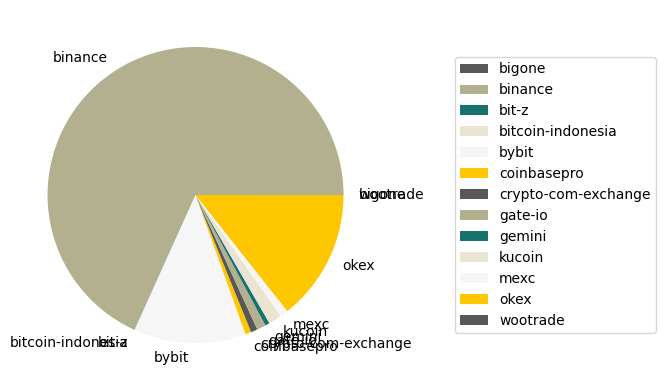

In [43]:
df_ldo_cex = aggregate_cex_balances(df_ldo)
print(df_ldo_cex.sort_values("balance", ascending=False).head(5))

create_pie_chart(df_ldo_cex, '../data/ldo_pie_chart_cex.png', labels=df_ldo_cex['cex'], show_legend=True)